# Waveform Generator for TDoA and GCC Testing

## Overview
This notebook implements a waveform generator for Time Difference of Arrival (TDoA) and Generalized Cross-Correlation (GCC) testing.

## Features
- Generate test signals for TDoA estimation
- Visualization tools for analysis

## Contents
1. Signal Generation
2. TDoA Simulation
3. Results and Visualization

In [10]:
from __future__ import annotations

import sys
from dataclasses import dataclass
from pathlib import Path
import importlib

import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import contextily as cx
from shapely.geometry import Point
from IPython.display import display

# Ensure matplotlib renders inline
%matplotlib inline

# Add repo root to path using relative navigation from notebook location
NOTEBOOK_DIR = Path.cwd()
REPO_ROOT = NOTEBOOK_DIR.parent.parent
sys.path.insert(0, str(REPO_ROOT))

# Reload all modules to pick up changes
import src.core as core_module
importlib.reload(core_module)

from src.core import (
    generate_signal,
    generate_chirp,
    save_iq_file,
    write_metadata,
    generate_pairwise_tdoa,
    plot_hyperbola_2d,
    get_bounds,
    match_fig_aspect,
    lonlat_to_xy_m,
    xy_m_to_lonlat,
)
from simulation.tdoa_sim import all_pairs


c = 299792458

@dataclass(frozen=True)
class SimMetadata:
    """Simulation metadata and output settings."""
    fs: float
    f_span: float
    f_center: float
    n_samples: int
    n_packets: int
    output_dir: str


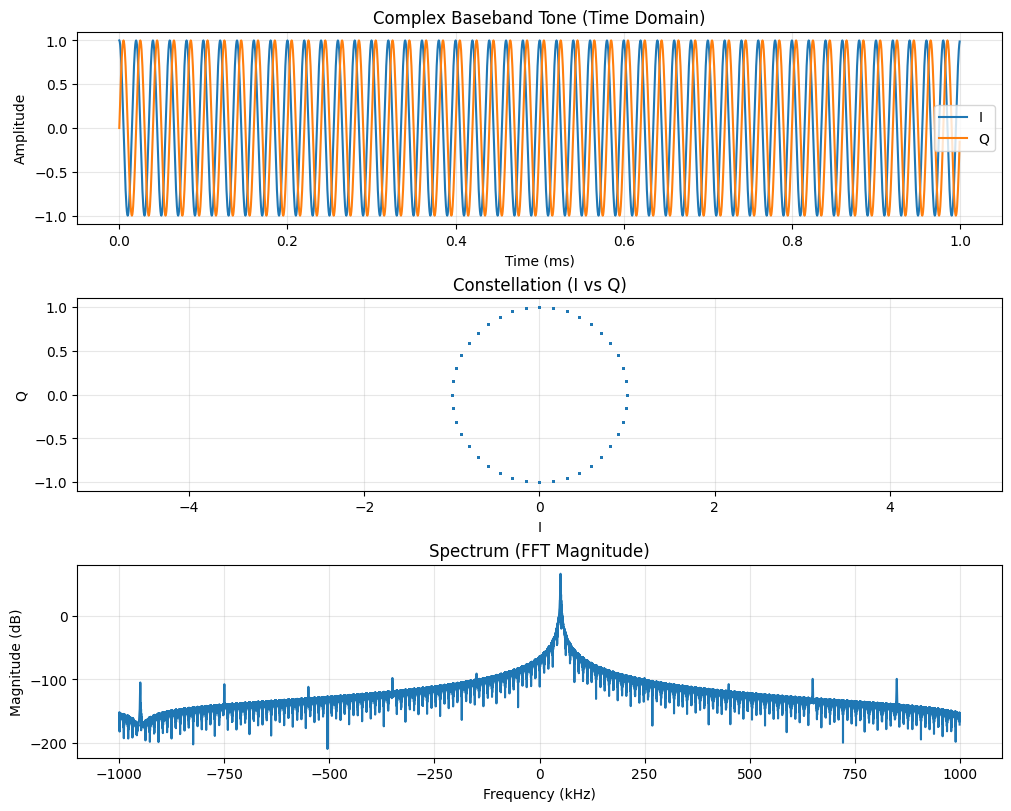

In [11]:
fs = 2_000_000.0
duration = 0.002  # 2 ms
f0 = 50_000.0
phase = 0.0

x = generate_signal(fs, duration, f0, phase=phase)

n_show = min(2000, x.size)
t = np.arange(n_show) / fs

fig, axs = plt.subplots(3, 1, figsize=(10, 8), constrained_layout=True)

# Time-domain I/Q

axs[0].plot(t * 1e3, x.real[:n_show], label="I")
axs[0].plot(t * 1e3, x.imag[:n_show], label="Q")
axs[0].set_title("Complex Baseband Tone (Time Domain)")
axs[0].set_xlabel("Time (ms)")
axs[0].set_ylabel("Amplitude")
axs[0].grid(True, alpha=0.3)
axs[0].legend()

# Constellation
axs[1].plot(x.real[:n_show], x.imag[:n_show], ".", markersize=2)
axs[1].set_title("Constellation (I vs Q)")
axs[1].set_xlabel("I")
axs[1].set_ylabel("Q")
axs[1].grid(True, alpha=0.3)
axs[1].axis("equal")

# Spectrum (magnitude, centered)
n_fft = 8192
w = np.hanning(min(n_fft, x.size))
xw = x[:w.size] * w
X = np.fft.fftshift(np.fft.fft(xw, n=n_fft))
f = np.fft.fftshift(np.fft.fftfreq(n_fft, d=1.0 / fs))

axs[2].plot(f / 1e3, 20 * np.log10(np.maximum(np.abs(X), 1e-12)))
axs[2].set_title("Spectrum (FFT Magnitude)")
axs[2].set_xlabel("Frequency (kHz)")
axs[2].set_ylabel("Magnitude (dB)")
axs[2].grid(True, alpha=0.3)

plt.show()

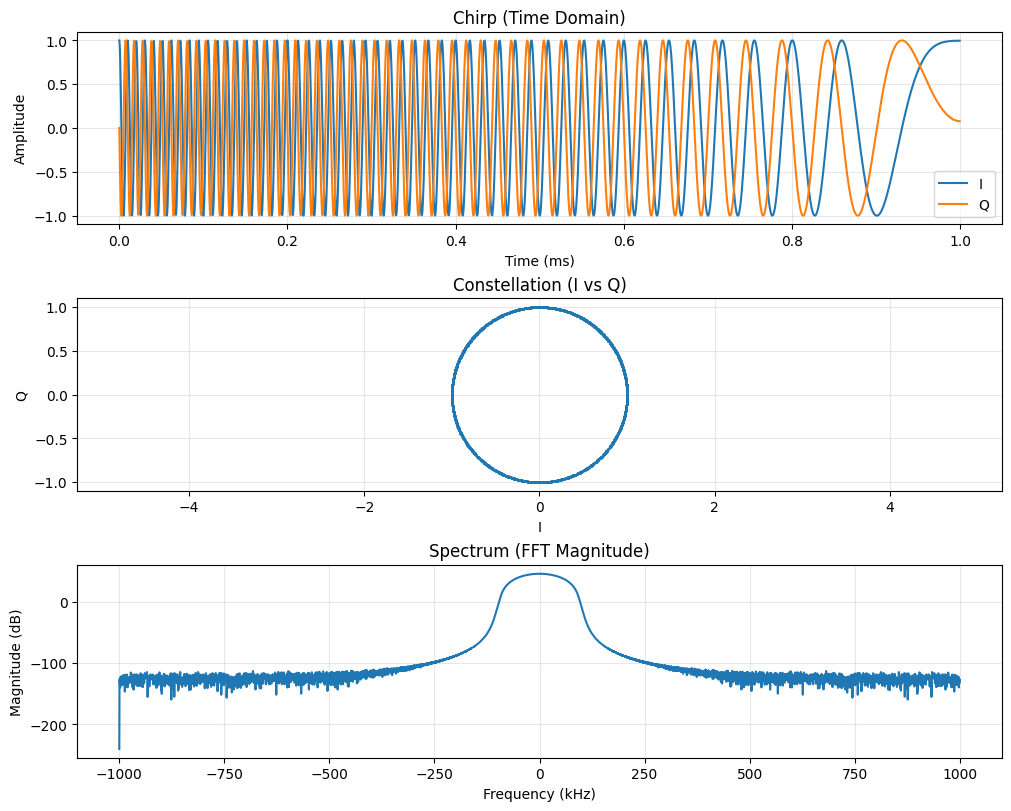

In [12]:
chirp = generate_chirp(fs=fs, n_samples=int(fs * duration), bandwidth=200_000.0, phase=0.0)

n_show = min(2000, chirp.size)
t = np.arange(n_show) / fs

plots, axs = plt.subplots(3, 1, figsize=(10, 8), constrained_layout=True)

# Time-domain I/Q

axs[0].plot(t * 1e3, chirp.real[:n_show], label="I")
axs[0].plot(t * 1e3, chirp.imag[:n_show], label="Q")
axs[0].set_title("Chirp (Time Domain)")
axs[0].set_xlabel("Time (ms)")
axs[0].set_ylabel("Amplitude")
axs[0].grid(True, alpha=0.3)
axs[0].legend()

# Constellation
axs[1].plot(chirp.real[:n_show], chirp.imag[:n_show], ".", markersize=2)
axs[1].set_title("Constellation (I vs Q)")
axs[1].set_xlabel("I")
axs[1].set_ylabel("Q")
axs[1].grid(True, alpha=0.3)
axs[1].axis("equal")

# Spectrum (magnitude, centered)
n_fft = 8192
w = np.hanning(min(n_fft, chirp.size))
chirp_w = chirp[:w.size] * w
X = np.fft.fftshift(np.fft.fft(chirp_w, n=n_fft))
f = np.fft.fftshift(np.fft.fftfreq(n_fft, d=1.0 / fs))

axs[2].plot(f / 1e3, 20 * np.log10(np.maximum(np.abs(X), 1e-12)))
axs[2].set_title("Spectrum (FFT Magnitude)")
axs[2].set_xlabel("Frequency (kHz)")
axs[2].set_ylabel("Magnitude (dB)")
axs[2].grid(True, alpha=0.3)

plt.show()


In [13]:
def _fractional_delay_fir(frac: float, num_taps: int) -> np.ndarray:
    """Design a windowed-sinc fractional delay FIR.

    Args:
        frac: Fractional delay in samples in [0, 1).
        num_taps: Number of FIR taps (odd recommended).

    Returns:
        Float64 FIR coefficients length num_taps.
    """
    if num_taps < 3:
        raise ValueError("num_taps must be >= 3")

    n = np.arange(num_taps, dtype=np.float64) - (num_taps - 1) / 2.0
    h = np.sinc(n - float(frac))
    h *= np.hamming(num_taps)
    h /= np.sum(h)
    return h

def apply_delay(
    x: np.ndarray,
    delay_samples: float,
    out_len: int,
    num_taps: int = 33,
) -> np.ndarray:
    """Delay a complex signal by a (possibly fractional) number of samples.

    This function performs:
      1) fractional delay via FIR (windowed sinc),
      2) integer shift into an output buffer.

    Args:
        x: Input complex samples.
        delay_samples: Desired delay in samples (>= 0).
        out_len: Output length in samples.
        num_taps: FIR taps for fractional delay.

    Returns:
        Complex64 array of length out_len containing the delayed signal.
    """
    if delay_samples < 0:
        raise ValueError("delay_samples must be >= 0")

    d_int = int(np.floor(delay_samples))
    frac = float(delay_samples - d_int)

    y = x.astype(np.complex64, copy=False)
    if frac > 1e-12:
        h = _fractional_delay_fir(frac, num_taps)
        # 'same' keeps length stable; adequate for simulation/testing.
        y = np.convolve(y, h.astype(np.float32), mode="same").astype(np.complex64)

    out = np.zeros(int(out_len), dtype=np.complex64)
    start = d_int
    if start >= out_len:
        return out

    n_copy = min(out_len - start, y.size)
    out[start:start + n_copy] = y[:n_copy]
    return out

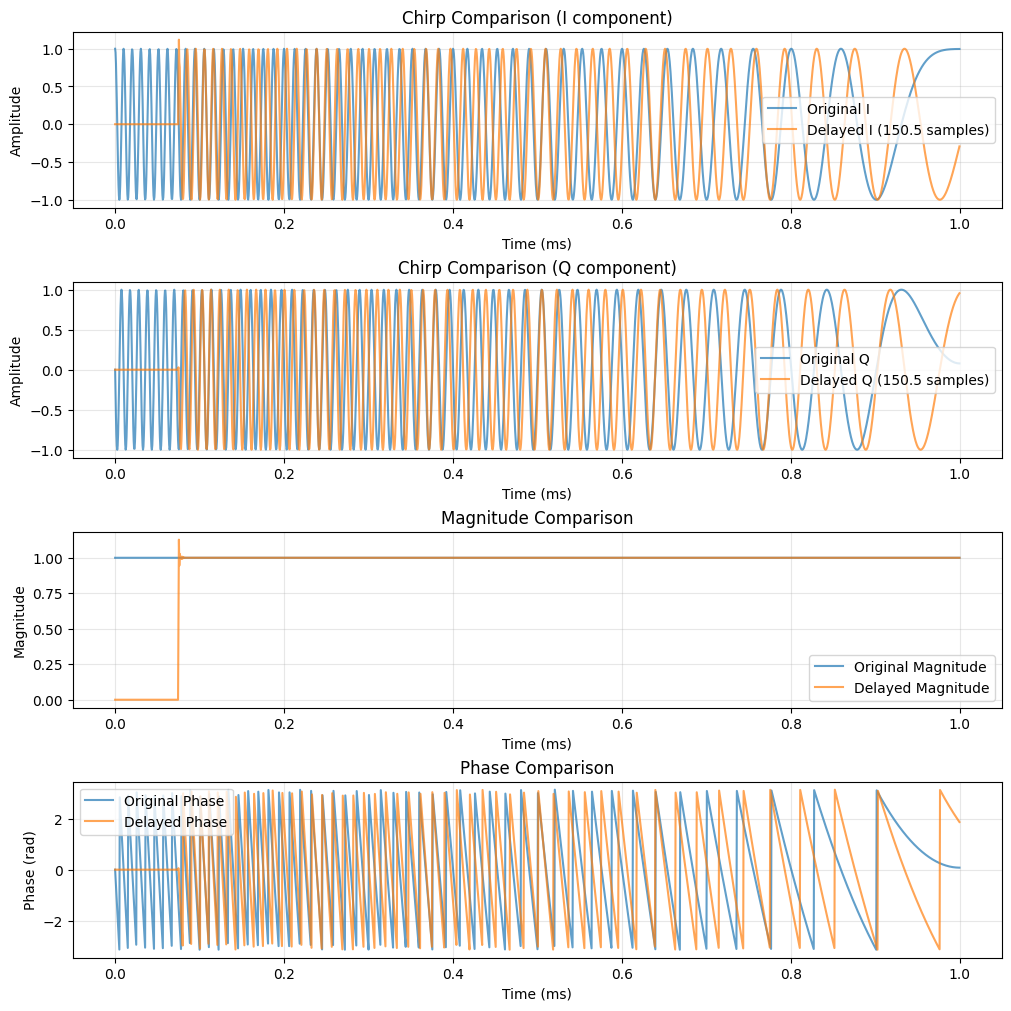

In [14]:
# Visualize the delayed chirp signal from apply_delay function
delay_test = 150.5  # Test with fractional delay
delayed_chirp = apply_delay(chirp, delay_test, out_len=chirp.size, num_taps=33)

n_show = min(2000, delayed_chirp.size)
t = np.arange(n_show) / fs

fig, axs = plt.subplots(4, 1, figsize=(10, 10), constrained_layout=True)

# Time-domain I/Q comparison
axs[0].plot(t * 1e3, chirp.real[:n_show], label="Original I", alpha=0.7)
axs[0].plot(t * 1e3, delayed_chirp.real[:n_show], label=f"Delayed I ({delay_test:.1f} samples)", alpha=0.7)
axs[0].set_title("Chirp Comparison (I component)")
axs[0].set_xlabel("Time (ms)")
axs[0].set_ylabel("Amplitude")
axs[0].grid(True, alpha=0.3)
axs[0].legend()

# Time-domain Q component
axs[1].plot(t * 1e3, chirp.imag[:n_show], label="Original Q", alpha=0.7)
axs[1].plot(t * 1e3, delayed_chirp.imag[:n_show], label=f"Delayed Q ({delay_test:.1f} samples)", alpha=0.7)
axs[1].set_title("Chirp Comparison (Q component)")
axs[1].set_xlabel("Time (ms)")
axs[1].set_ylabel("Amplitude")
axs[1].grid(True, alpha=0.3)
axs[1].legend()

# Magnitude comparison
axs[2].plot(t * 1e3, np.abs(chirp[:n_show]), label="Original Magnitude", alpha=0.7)
axs[2].plot(t * 1e3, np.abs(delayed_chirp[:n_show]), label=f"Delayed Magnitude", alpha=0.7)
axs[2].set_title("Magnitude Comparison")
axs[2].set_xlabel("Time (ms)")
axs[2].set_ylabel("Magnitude")
axs[2].grid(True, alpha=0.3)
axs[2].legend()

# Phase comparison
axs[3].plot(t * 1e3, np.angle(chirp[:n_show]), label="Original Phase", alpha=0.7)
axs[3].plot(t * 1e3, np.angle(delayed_chirp[:n_show]), label=f"Delayed Phase", alpha=0.7)
axs[3].set_title("Phase Comparison")
axs[3].set_xlabel("Time (ms)")
axs[3].set_ylabel("Phase (rad)")
axs[3].grid(True, alpha=0.3)
axs[3].legend()

plt.show()

In [15]:
def lonlat_to_xy_m(lonlat_deg: np.ndarray) -> np.ndarray:
    """Convert (lon, lat) degrees -> (x, y) meters using EPSG:3857."""
    lonlat_deg = np.asarray(lonlat_deg, dtype=np.float64)
    pts = [Point(float(lon), float(lat)) for lon, lat in lonlat_deg]
    g = gpd.GeoSeries(pts, crs="EPSG:4326").to_crs(epsg=3857)
    return np.array([(float(p.x), float(p.y)) for p in g], dtype=np.float64)

In [16]:
def toa_delay_samples(rx_lonlat: np.ndarray, tx_lonlat: np.ndarray, fs: float, c: float = c) -> np.ndarray:
    """Compute absolute TOA delays (in samples) from one TX to multiple RX."""
    rx_xy = lonlat_to_xy_m(rx_lonlat)
    tx_xy = lonlat_to_xy_m(np.asarray(tx_lonlat, dtype=np.float64).reshape(1, 2))[0]
    dist_m = np.linalg.norm(rx_xy - tx_xy, axis=1)
    tau_s = dist_m / float(c)
    return tau_s * float(fs)

 Random Drone Position:
   Distance from center: 2.77 km
   Angle: 234.1°
   Coordinates (lon, lat): (34.783960, 50.906293)
 Map bounds: x=[3865826, 3881812], y=[6602119, 6611710]
 Drone position: x=3872133, y=6604735
 Map created with drone marker!


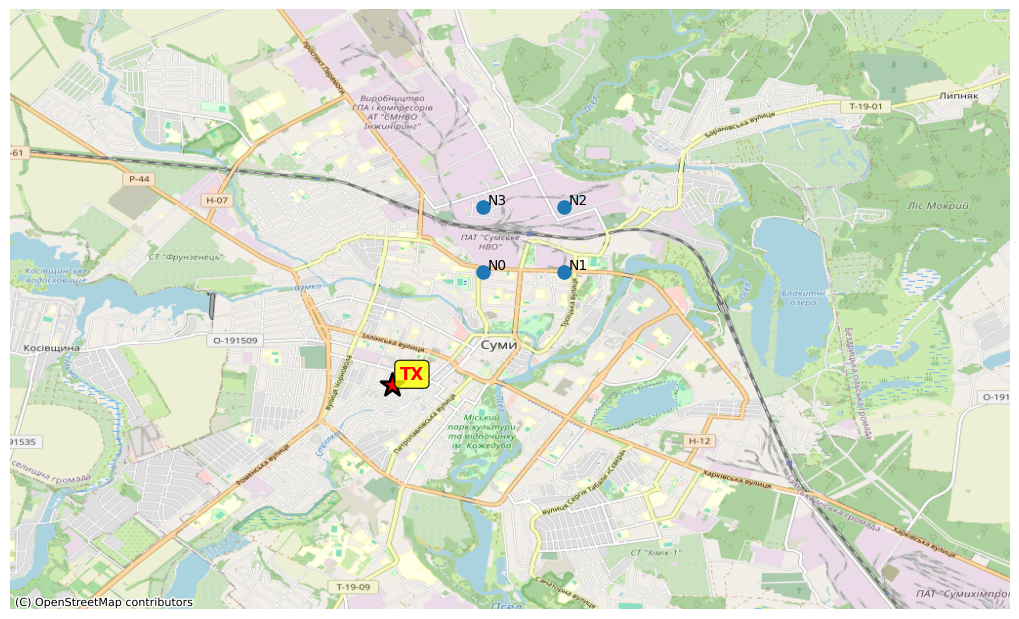


 Signal Propagation:
   Relative delays (samples): [ 0.    7.12 14.76  9.43]
   Relative delays (µs):      [0.    3.561 7.382 4.713]
   Max delay difference:      7.382 µs


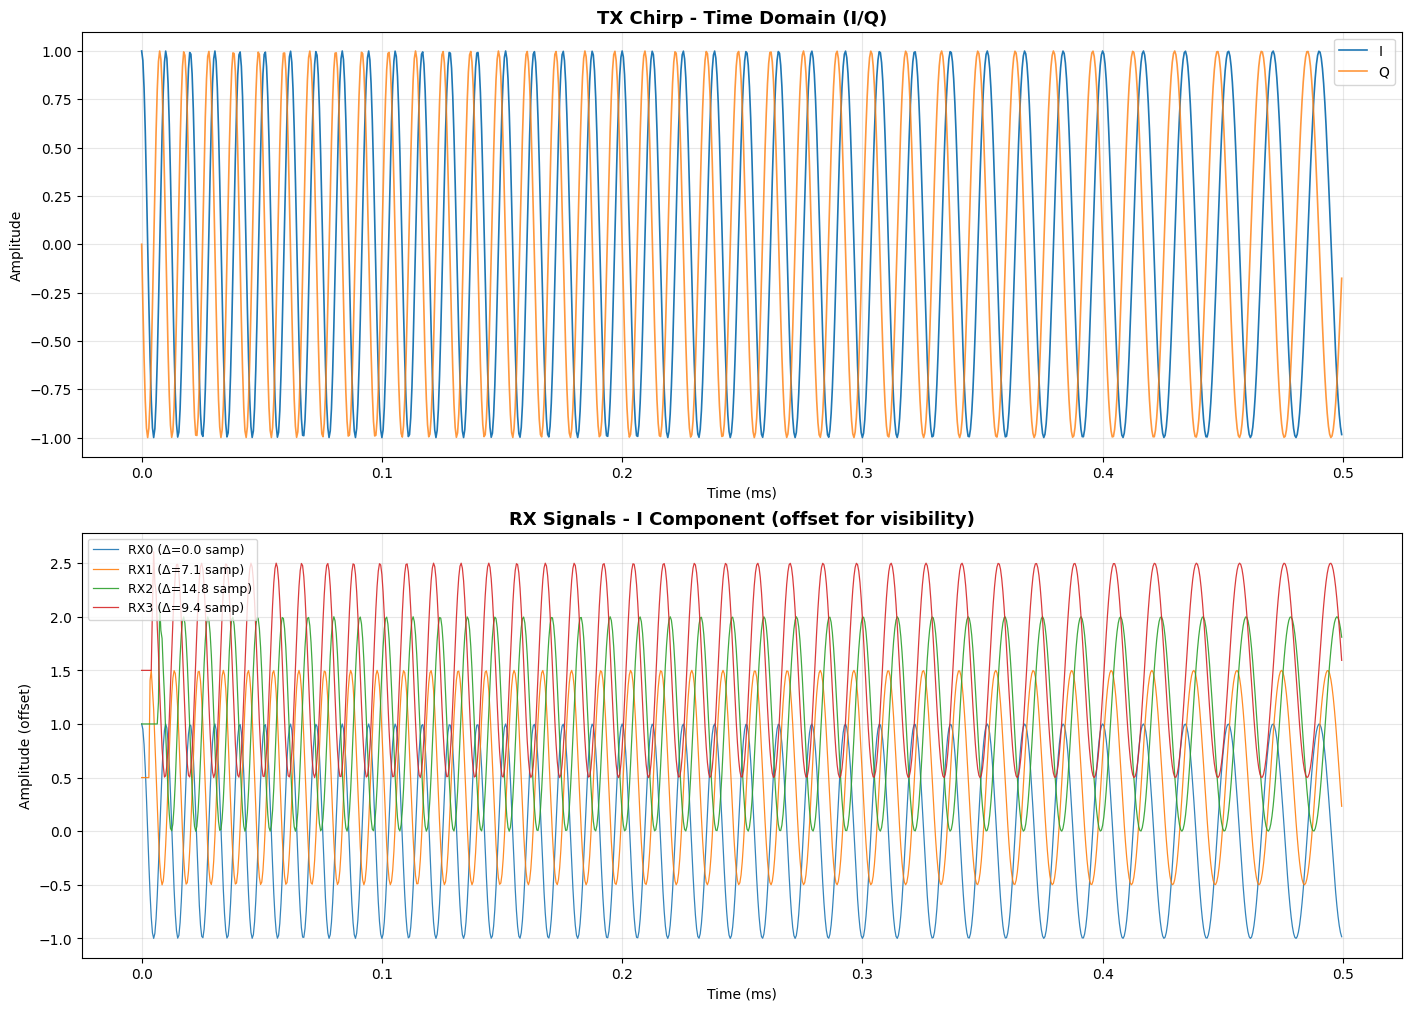

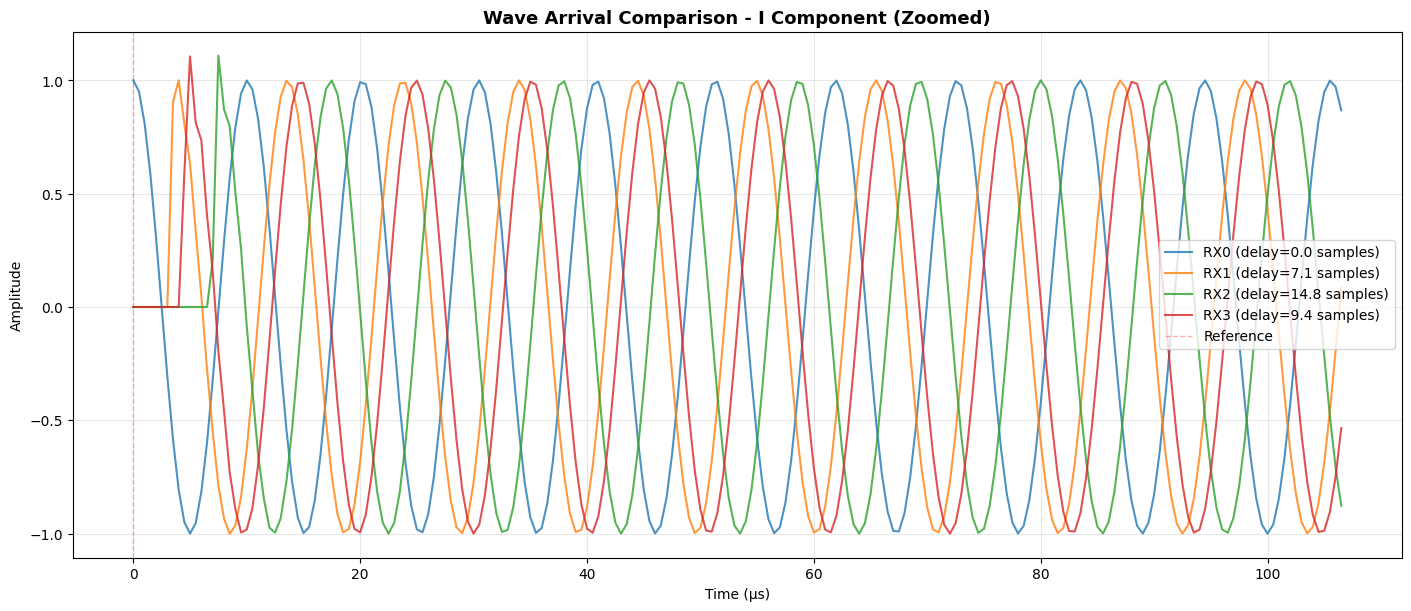

In [19]:
# Setup receiver nodes (4 nodes in square formation)
base_lon, base_lat = 34.8000, 50.9220  # around Sumy
n_rx = 4
spacing_km = 1.0
n_samples = chirp.size

deg_per_km_lat = 1.0 / 111.32
deg_per_km_lon = 1.0 / (111.32 * np.cos(np.deg2rad(base_lat)))

# Square layout (lon, lat): (0,0), (1,0), (1,1), (0,1) km offsets
receivers = np.array(
    [
        [base_lon + 0.0 * spacing_km * deg_per_km_lon, base_lat + 0.0 * spacing_km * deg_per_km_lat],
        [base_lon + 1.0 * spacing_km * deg_per_km_lon, base_lat + 0.0 * spacing_km * deg_per_km_lat],
        [base_lon + 1.0 * spacing_km * deg_per_km_lon, base_lat + 1.0 * spacing_km * deg_per_km_lat],
        [base_lon + 0.0 * spacing_km * deg_per_km_lon, base_lat + 1.0 * spacing_km * deg_per_km_lat],
    ],
    dtype=np.float64,
)

# Generate random drone position within 5km range
center_lon = base_lon + 0.5 * spacing_km * deg_per_km_lon
center_lat = base_lat + 0.5 * spacing_km * deg_per_km_lat

# Random angle and distance
np.random.seed(18)  # For reproducibility
angle = np.random.uniform(0, 2 * np.pi)
distance_km = np.random.uniform(0.5, 5.0)

tx_lon = center_lon + distance_km * np.cos(angle) * deg_per_km_lon
tx_lat = center_lat + distance_km * np.sin(angle) * deg_per_km_lat
tx_lonlat = np.array([tx_lon, tx_lat], dtype=np.float64)

print(f" Random Drone Position:")
print(f"   Distance from center: {distance_km:.2f} km")
print(f"   Angle: {np.rad2deg(angle):.1f}°")
print(f"   Coordinates (lon, lat): ({tx_lon:.6f}, {tx_lat:.6f})")

# Convert all positions to meters FIRST
receivers_gdf = gpd.GeoDataFrame(
    geometry=[Point(lon, lat) for lon, lat in receivers],
    crs="EPSG:4326"
).to_crs(epsg=3857)
receivers_xy = np.array([(p.x, p.y) for p in receivers_gdf.geometry])

drone_gdf = gpd.GeoSeries([Point(tx_lon, tx_lat)], crs="EPSG:4326").to_crs(epsg=3857)
drone_xy = np.array([drone_gdf.iloc[0].x, drone_gdf.iloc[0].y])

# Calculate proper bounds INCLUDING the drone BEFORE creating the map
xmin, xmax, ymin, ymax = get_bounds(receivers_xy, extra_points=[drone_xy])

# Create the map
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_position([0, 0, 1, 1])

# Plot receivers
receivers_gdf.plot(ax=ax, markersize=90, zorder=5)
for k, p in enumerate(receivers_gdf.geometry):
    ax.text(p.x + 80, p.y + 80, f"N{k}", zorder=6)

# Apply aspect ratio correction
xmin, xmax, ymin, ymax = match_fig_aspect(
    xmin, xmax, ymin, ymax,
    fig.get_figwidth(), fig.get_figheight()
)

# Set bounds BEFORE adding basemap
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect("auto")

print(f" Map bounds: x=[{xmin:.0f}, {xmax:.0f}], y=[{ymin:.0f}, {ymax:.0f}]")
print(f" Drone position: x={drone_xy[0]:.0f}, y={drone_xy[1]:.0f}")

# NOW add basemap with the correct bounds
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, reset_extent=False)
ax.set_axis_off()

# Add the drone marker directly to the current axes
drone_marker = ax.scatter([drone_xy[0]], [drone_xy[1]], marker="*", s=300, c="red", 
                          edgecolors="black", linewidths=2, zorder=10, label="TX Drone")
drone_label = ax.text(drone_xy[0] + 150, drone_xy[1] + 150, "TX", zorder=20,
                      fontsize=12, weight="bold", color="red",
                      bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.8))

# Verify drone is inside
is_inside = (xmin <= drone_xy[0] <= xmax) and (ymin <= drone_xy[1] <= ymax)
print(f" Map created with drone marker!")

plt.show()

# Compute time-of-arrival delays
d_abs = toa_delay_samples(receivers, tx_lonlat, fs)
d_rel = d_abs - np.min(d_abs)

print(f"\n Signal Propagation:")
print(f"   Relative delays (samples): {np.round(d_rel, 2)}")
print(f"   Relative delays (µs):      {np.round(d_rel / fs * 1e6, 3)}")
print(f"   Max delay difference:      {np.max(d_rel) / fs * 1e6:.3f} µs")

# Generate received signals with delays
rx_sigs = [apply_delay(chirp, float(d), out_len=n_samples, num_taps=33) for d in d_rel]

# Visualizations
n_show = min(1000, n_samples)
t_ms = (np.arange(n_show) / fs) * 1e3

# 1. TX and RX Signal Comparison
fig, axs = plt.subplots(2, 1, figsize=(14, 10), constrained_layout=True)

# TX I/Q time domain
axs[0].plot(t_ms, chirp.real[:n_show], label="I", linewidth=1.2)
axs[0].plot(t_ms, chirp.imag[:n_show], label="Q", alpha=0.8, linewidth=1.2)
axs[0].set_title("TX Chirp - Time Domain (I/Q)", fontweight='bold', fontsize=13)
axs[0].set_xlabel("Time (ms)")
axs[0].set_ylabel("Amplitude")
axs[0].grid(True, alpha=0.3)
axs[0].legend()

# RX Signals - I component comparison
colors = ['C0', 'C1', 'C2', 'C3']
for i in range(n_rx):
    offset = i * 0.5  # Vertical offset for clarity
    axs[1].plot(t_ms, rx_sigs[i].real[:n_show] + offset, 
                   label=f"RX{i} (Δ={d_rel[i]:.1f} samp)", 
                   color=colors[i], linewidth=0.9, alpha=0.9)
axs[1].set_title("RX Signals - I Component (offset for visibility)", fontweight='bold', fontsize=13)
axs[1].set_xlabel("Time (ms)")
axs[1].set_ylabel("Amplitude (offset)")
axs[1].grid(True, alpha=0.3)
axs[1].legend(fontsize=9)

plt.show()

# 2. Detailed Wave Visualization (zoomed in on delay differences)
fig2, ax2 = plt.subplots(1, 1, figsize=(14, 6), constrained_layout=True)

# Focus on the arrival of the signal at different receivers
zoom_start = int(np.min(d_rel) - 50)
zoom_end = int(np.max(d_rel) + 200)
zoom_start = max(0, zoom_start)
zoom_end = min(n_samples, zoom_end)
n_zoom = zoom_end - zoom_start
t_zoom_us = (np.arange(n_zoom) / fs) * 1e6

# Zoomed I component
for i in range(n_rx):
    ax2.plot(t_zoom_us, rx_sigs[i].real[zoom_start:zoom_end], 
             label=f"RX{i} (delay={d_rel[i]:.1f} samples)", 
             linewidth=1.5, alpha=0.8)
ax2.axvline(0, color='red', linestyle='--', alpha=0.3, linewidth=1, label='Reference')
ax2.set_title("Wave Arrival Comparison - I Component (Zoomed)", fontweight='bold', fontsize=13)
ax2.set_xlabel("Time (µs)")
ax2.set_ylabel("Amplitude")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.show()


In [ ]:
from datetime import datetime

def iq_wrapper(
    rx_signals: list[np.ndarray],
    rx_coordinates: np.ndarray,
    tx_coordinates: np.ndarray | None = None,
    fs: float = 2_000_000.0,
    n_samples: int = 362,
    n_packets: int = 1440,
    output_base_dir: str = "data/output"
) -> None:
    """Wrap simulated signals into .iq files with specified packet structure.
    
    Args:
        rx_signals: List of complex signal arrays (one per receiver)
        rx_coordinates: Array of shape (n_receivers, 2) with [lon, lat] in degrees
        tx_coordinates: Optional array [lon, lat] for transmitter position in degrees
        fs: Sample rate in Hz
        n_samples: Number of samples per packet (default: 362)
        n_packets: Number of packets per file (default: 1440)
        output_base_dir: Base directory for output files (relative to notebook dir)
    
    Saves files as: output_base_dir/HH_MM_DD_MM/{0-3}_RX.iq and metadata.txt
    """
    
    # Create timestamp directory name (HH_MM_DD_MM format)
    now = datetime.now()
    timestamp_dir = now.strftime("%H_%M_%d_%m")
    output_dir = NOTEBOOK_DIR / output_base_dir / timestamp_dir
    output_dir.mkdir(parents=True, exist_ok=True)
    
    total_samples_needed = n_samples * n_packets
    
    for rx_idx, signal in enumerate(rx_signals):
        # Save the delayed signal directly - just truncate or pad to match length
        if signal.size >= total_samples_needed:
            # Use first total_samples_needed samples
            output_signal = signal[:total_samples_needed]
        else:
            # Pad with zeros if signal is too short
            output_signal = np.zeros(total_samples_needed, dtype=np.complex64)
            output_signal[:signal.size] = signal
        
        # Save using core module function
        output_file = output_dir / f"{rx_idx}_RX.iq"
        save_iq_file(output_file, output_signal)
        
        print(f"Saved {output_file.name} ({total_samples_needed} samples, {signal.size} original)")
    
    # Save metadata using core module function
    write_metadata(
        output_dir / "metadata.txt",
        fs=fs,
        n_samples=n_samples,
        n_packets=n_packets,
        receivers=rx_coordinates,
        tx_pos=tx_coordinates
    )
    
    print(f"Metadata saved to: {output_dir / 'metadata.txt'}")
    print(f"\nAll files saved to: {output_dir}")

# Test the function with current rx_sigs
iq_wrapper(rx_sigs, rx_coordinates=receivers, tx_coordinates=tx_lonlat, 
           fs=fs, n_samples=362, n_packets=1440)


Saved 0_RX.iq (1440 packets × 362 samples)
Saved 1_RX.iq (1440 packets × 362 samples)
Saved 2_RX.iq (1440 packets × 362 samples)
Saved 3_RX.iq (1440 packets × 362 samples)
Metadata saved to: c:\Users\vlady\Desktop\built-for-ukraine\drone_detection_rf_2026\drone_detection_rf_2026\docs\notebooks\data\output\17_59_19_01\metadata.txt

All files saved to: c:\Users\vlady\Desktop\built-for-ukraine\drone_detection_rf_2026\drone_detection_rf_2026\docs\notebooks\data\output\17_59_19_01
